# Efficient net embeddings

Hyperparameter tuning was done manually. Hyperparameters were not searched extensively, due to GPU limits which I run in to quite often. Starting point for hyperparameters were taken from here http://cs230.stanford.edu/projects_winter_2020/reports/32610274.pdf, but different optimizer and parametrization was used in the end.

Verify GPU type

In [2]:
!nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv

name, driver_version, memory.total [MiB]
Tesla T4, 460.32.03, 15109 MiB


## Preprocess and load data

Import and load all the data. Data should be stored in Google Drive. 

Data should be separated categorically in to .npz files. This file-sorting can be done as stated in README.

In [2]:
import datetime
import io
import os
import pickle

import wandb
import torch
import torch.nn as nn
from efficientnet_pytorch import EfficientNet

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import torchvision.models as models
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from src.data.preprocess_data import DatasetManager
from tqdm import tqdm

# S3 bucket
import boto3
from dotenv import dotenv_values

In [4]:
def extract_features(loader):
    embeddings = []
    labels = []
    
    with torch.no_grad():
        for X, y in tqdm(loader):
            X, y = X.to(device), y
            features = model.extract_features(X)
            # Flatten features
            feat_flat = features.detach().flatten(1).cpu().numpy()
            
            labels.append(y.numpy())
            embeddings.append(feat_flat)
            
    return embeddings, labels

def load_embedding(mode: str):
    assert mode in ['train', 'test', 'val'], "Mode must be either 'train', 'test', or 'val'"
    
    X = np.load(f'../data/processed/X_{mode}_embeddings.npy', mmap_mode='r')
    y = np.load(f'../data/processed/y_{mode}_labels.npy', mmap_mode='r')
    y = y.reshape(-1)
    return X, y

def initialize_pca(n_components, X_train, X_test, X_val):
    pca = PCA(n_components=n_components)
    X_train_transformed = pca.fit_transform(X_train)
    X_test_transformed = pca.transform(X_test)
    X_val_transformed = pca.transform(X_val)
    return pca, X_train_transformed, X_test_transformed, X_val_transformed

Define constants to be used later. *DRIVE_PATH* and *MODEL_PATH* should be the root path of project and path for models, respectively

In [5]:
EMOTION_LIST = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
DRIVE_PATH = "/content/drive/My Drive/Loop Q prize"
MODEL_PATH = 'models/resnet50'

# Set values
BATCH_SIZE = 8
VAL_SIZE = 0.2
N_EPOCHS = 100
INPUT_SIZE = 224
N_FEATURES = len(EMOTION_LIST)

In [6]:
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(INPUT_SIZE),
    transforms.RandomAffine(degrees=10, translate=(0.2, 0.2)),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(INPUT_SIZE),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset_manager = DatasetManager(batch_size=BATCH_SIZE, test_size=0.2, 
                        validation_size=0.2, transform=preprocess, 
                        test_transform=test_preprocess)


train_loader, test_loader, val_loader = dataset_manager.load_dataloaders()

## Load model

This is only needed to construct embeddings. If embeddings are already constructed, you can move to training part. Load model. Efficient net provides 1280x7x7 image embedding which is huge, but we may be able to process it with simple algorithms and/or reduce the dimensionality

In [4]:
model = EfficientNet.from_pretrained('efficientnet-b0')
model.eval()

Loaded pretrained weights for efficientnet-b0


EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=

Choose device and transfer model there

In [5]:
# Create logging, initialize device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=

Extract features on train, test, and val. This generates large files, but is necessary to retain all of the information

In [12]:
# Train
embeddings, labels = extract_features(train_loader)
np.save('../data/processed/y_train_labels.npy', np.vstack(labels[:-1]))
np.save('../data/processed/X_train_embeddings.npy', np.vstack(embeddings[:-1]))
# Test
embeddings, labels = extract_features(test_loader)
np.save('../data/processed/y_test_labels.npy', np.vstack(labels[:-1]))
np.save('../data/processed/X_test_embeddings.npy', np.vstack(embeddings[:-1]))
# Val
embeddings, labels = extract_features(val_loader)
np.save('../data/processed/y_val_labels.npy', np.vstack(labels[:-1]))
np.save('../data/processed/X_val_embeddings.npy', np.vstack(embeddings[:-1]))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 504/504 [00:35<00:00, 14.03it/s]


## Training

Load train embeddings, if they are already saved

In [9]:
X_train, y_train = load_embedding('train')
X_test, y_test = load_embedding('test')
X_val, y_val = load_embedding('val')

Try dimensionality reduction

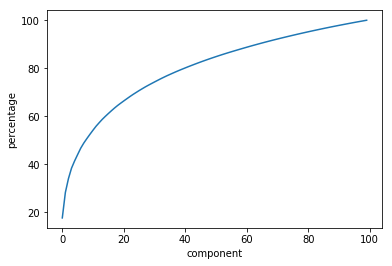

In [16]:
pca, X_train_transformed, X_test_transformed, X_val_transformed = initialize_pca(100, X_train, X_test, X_val)
_ = plt.plot(100 * np.cumsum(pca.explained_variance_ / pca.explained_variance_.sum()))
plt.xlabel("component")
plt.ylabel("percentage")
plt.show()

### Find best sklearn algorithm

Find best KNN algorithm and save

In [66]:
data = dataset_manager.load_dataloaders(return_raw_data=True)
X_train, X_test, X_val = [x[1] for x in data['X'].items()]
y_train, y_test, y_val = [x[1] for x in data['y'].items()]

n_rows_train = X_train.shape[0]
n_rows_val = X_val.shape[0]
n_rows_test = X_test.shape[0]
X_train_flatten = X_train.reshape(n_rows_train, -1)
X_val_flatten = X_val.reshape(n_rows_val, -1)
X_test_flatten = X_test.reshape(n_rows_test, -1)

In [67]:
from sklearn.neighbors import KNeighborsClassifier
best_score = 0
best_n = 0
for n in range(1, 50, 5):    
    neigh = KNeighborsClassifier(n_neighbors=n)
    neigh.fit(X_train_flatten, y_train)
    score = neigh.score(X_val_flatten, y_val)
    if score > best_score:
        best_score = score
        best_n = n
    print(f"n: {n}, Score: {score}")

neigh = KNeighborsClassifier(n_neighbors=best_n)
neigh.fit(X_train_transformed, y_train)
pickle.dump(neigh, open('../models/knn', 'wb'))

KeyboardInterrupt: 

Try Linear probing

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.0s finished


0.4540258449304175

## Find best model with wandb

In [35]:
import xgboost as xgb
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
def logisticRegressionClassifier():
    clf = LogisticRegression(solver='lbfgs', max_iter=4000)
    clf.fit(X_train_transformed, y_train)
    preds = clf.predict(X_test_transformed)
    pred_prob = clf.predict_proba(X_test_transformed)
    print(metrics.classification_report(y_test, preds))

    wandb.log({'accuracy_score': metrics.accuracy_score(y_test,preds)})
    wandb.sklearn.plot_classifier(clf, X_train_transformed, X_test_transformed, 
                                  y_train, y_test, preds, pred_prob, clf.classes_,
                                  model_name='LogisticRegression', feature_names=None)


def xgbClassifier():
    print('xgboost')
    param={}
    xg_train = xgb.DMatrix(X_train_transformed, label=y_train)
    xg_test = xgb.DMatrix(X_test_transformed, label=y_test)
    watchlist = [(xg_train, 'train'), (xg_test, 'test')]
    param['objective'] = 'multi:softmax'
    # scale weight of positive examples
    param['eta'] = 0.1
    param['num_class'] = 7
    bst = xgb.train(param, xg_train, 5, watchlist, callbacks=[wandb.xgboost.wandb_callback()])
    preds = bst.predict(xg_test)
    wandb.log({'accuracy_score': metrics.accuracy_score(y_test,preds)})


In [39]:
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'accuracy_score',
      'goal': 'maximize'   
    },
    'parameters': {
        'model':{
            'values':['logistic','xgboost']
}}}
sweep_id = wandb.sweep(sweep_config)

def train():
    wandb.init()
    if wandb.config.model == 'logistic':
        logisticRegressionClassifier()
    if wandb.config.model == 'xgboost':
        xgbClassifier()

Create sweep with ID: 1kpno24x
Sweep URL: https://wandb.ai/teemuso/uncategorized/sweeps/1kpno24x


In [40]:
wandb.agent(sweep_id, function=train)

wandb: Agent Starting Run: 4akxao30 with config:
wandb: 	model: xgboost


xgboost
[0]	train-mlogloss:1.89792	test-mlogloss:1.91490
[1]	train-mlogloss:1.85501	test-mlogloss:1.88714
[2]	train-mlogloss:1.81593	test-mlogloss:1.86310
[3]	train-mlogloss:1.77959	test-mlogloss:1.84054
[4]	train-mlogloss:1.74634	test-mlogloss:1.82124


train-mlogloss,1.74634
test-mlogloss,1.82124
_runtime,8
_timestamp,1622980176
_step,5
accuracy_score,0.35692


train-mlogloss,█▆▄▃▁
test-mlogloss,█▆▄▂▁
_runtime,▁▅▅▅██
_timestamp,▁▅▅▅██
_step,▁▂▄▅▇█
accuracy_score,▁


wandb: Agent Starting Run: vt6k3s1h with config:
wandb: 	model: logistic


wandb: 
wandb: Plotting LogisticRegression.


              precision    recall  f1-score   support

         0.0       0.38      0.22      0.28       689
         1.0       0.33      0.03      0.05        80
         2.0       0.33      0.31      0.32       721
         3.0       0.56      0.72      0.63      1263
         4.0       0.36      0.34      0.35       853
         5.0       0.54      0.60      0.57       567
         6.0       0.39      0.40      0.39       859

    accuracy                           0.45      5032
   macro avg       0.41      0.37      0.37      5032
weighted avg       0.43      0.45      0.43      5032



wandb: Logged feature importances.
wandb: Logged learning curve.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision recall curve.


accuracy_score,0.44992
_runtime,83
_timestamp,1622980263
_step,8


accuracy_score,▁
_runtime,▁▁▆▆▇▇▇██
_timestamp,▁▁▆▆▇▇▇██
_step,▁▂▃▄▅▅▆▇█


wandb: Agent Starting Run: 6665g7wr with config:
wandb: 	model: xgboost


xgboost


C:\Users\teemu\anaconda3\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[0]	train-mlogloss:1.89792	test-mlogloss:1.91490
[1]	train-mlogloss:1.85501	test-mlogloss:1.88714
[2]	train-mlogloss:1.81593	test-mlogloss:1.86310
[3]	train-mlogloss:1.77959	test-mlogloss:1.84054
[4]	train-mlogloss:1.74634	test-mlogloss:1.82124


train-mlogloss,1.74634
test-mlogloss,1.82124
_runtime,8
_timestamp,1622980279
_step,5
accuracy_score,0.35692


train-mlogloss,█▆▄▃▁
test-mlogloss,█▆▄▂▁
_runtime,▁▅▅▅██
_timestamp,▁▅▅▅██
_step,▁▂▄▅▇█
accuracy_score,▁


wandb: Agent Starting Run: 28d6olgi with config:
wandb: 	model: logistic


wandb: 
wandb: Plotting LogisticRegression.


              precision    recall  f1-score   support

         0.0       0.38      0.22      0.28       689
         1.0       0.33      0.03      0.05        80
         2.0       0.33      0.31      0.32       721
         3.0       0.56      0.72      0.63      1263
         4.0       0.36      0.34      0.35       853
         5.0       0.54      0.60      0.57       567
         6.0       0.39      0.40      0.39       859

    accuracy                           0.45      5032
   macro avg       0.41      0.37      0.37      5032
weighted avg       0.43      0.45      0.43      5032



wandb: Logged feature importances.
wandb: Logged learning curve.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision recall curve.


accuracy_score,0.44992
_runtime,84
_timestamp,1622980367
_step,8


accuracy_score,▁
_runtime,▁▁▆▆▇▇▇██
_timestamp,▁▁▆▆▇▇▇██
_step,▁▂▃▄▅▅▆▇█


wandb: Agent Starting Run: z23oiafn with config:
wandb: 	model: xgboost


xgboost


C:\Users\teemu\anaconda3\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[0]	train-mlogloss:1.89792	test-mlogloss:1.91490
[1]	train-mlogloss:1.85501	test-mlogloss:1.88714
[2]	train-mlogloss:1.81593	test-mlogloss:1.86310
[3]	train-mlogloss:1.77959	test-mlogloss:1.84054
[4]	train-mlogloss:1.74634	test-mlogloss:1.82124


train-mlogloss,1.74634
test-mlogloss,1.82124
_runtime,9
_timestamp,1622980384
_step,5
accuracy_score,0.35692


train-mlogloss,█▆▄▃▁
test-mlogloss,█▆▄▂▁
_runtime,▁▅▅▅██
_timestamp,▁▅▅▅██
_step,▁▂▄▅▇█
accuracy_score,▁


wandb: Agent Starting Run: 2g59nb9x with config:
wandb: 	model: logistic


wandb: 
wandb: Plotting LogisticRegression.


              precision    recall  f1-score   support

         0.0       0.38      0.22      0.28       689
         1.0       0.33      0.03      0.05        80
         2.0       0.33      0.31      0.32       721
         3.0       0.56      0.72      0.63      1263
         4.0       0.36      0.34      0.35       853
         5.0       0.54      0.60      0.57       567
         6.0       0.39      0.40      0.39       859

    accuracy                           0.45      5032
   macro avg       0.41      0.37      0.37      5032
weighted avg       0.43      0.45      0.43      5032



wandb: Logged feature importances.
wandb: Logged learning curve.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision recall curve.


accuracy_score,0.44992
_runtime,84
_timestamp,1622980472
_step,8


accuracy_score,▁
_runtime,▁▁▆▆▇▇▇██
_timestamp,▁▁▆▆▇▇▇██
_step,▁▂▃▄▅▅▆▇█


wandb: Agent Starting Run: qw2426zu with config:
wandb: 	model: xgboost


xgboost


C:\Users\teemu\anaconda3\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[0]	train-mlogloss:1.89792	test-mlogloss:1.91490
[1]	train-mlogloss:1.85501	test-mlogloss:1.88714
[2]	train-mlogloss:1.81593	test-mlogloss:1.86310
[3]	train-mlogloss:1.77959	test-mlogloss:1.84054
[4]	train-mlogloss:1.74634	test-mlogloss:1.82124


train-mlogloss,1.74634
test-mlogloss,1.82124
_runtime,9
_timestamp,1622980487
_step,5
accuracy_score,0.35692


train-mlogloss,█▆▄▃▁
test-mlogloss,█▆▄▂▁
_runtime,▁▅▅▅██
_timestamp,▁▅▅▅██
_step,▁▂▄▅▇█
accuracy_score,▁


wandb: Agent Starting Run: khjnf5aq with config:
wandb: 	model: logistic


wandb: 
wandb: Plotting LogisticRegression.


              precision    recall  f1-score   support

         0.0       0.38      0.22      0.28       689
         1.0       0.33      0.03      0.05        80
         2.0       0.33      0.31      0.32       721
         3.0       0.56      0.72      0.63      1263
         4.0       0.36      0.34      0.35       853
         5.0       0.54      0.60      0.57       567
         6.0       0.39      0.40      0.39       859

    accuracy                           0.45      5032
   macro avg       0.41      0.37      0.37      5032
weighted avg       0.43      0.45      0.43      5032



wandb: Logged feature importances.
wandb: Logged learning curve.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision recall curve.


accuracy_score,0.44992
_runtime,84
_timestamp,1622980575
_step,8


accuracy_score,▁
_runtime,▁▁▆▆▇▇▇██
_timestamp,▁▁▆▆▇▇▇██
_step,▁▂▃▄▅▅▆▇█


wandb: Agent Starting Run: hh3y3x4z with config:
wandb: 	model: xgboost


xgboost


C:\Users\teemu\anaconda3\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[0]	train-mlogloss:1.89792	test-mlogloss:1.91490
[1]	train-mlogloss:1.85501	test-mlogloss:1.88714
[2]	train-mlogloss:1.81593	test-mlogloss:1.86310
[3]	train-mlogloss:1.77959	test-mlogloss:1.84054
[4]	train-mlogloss:1.74634	test-mlogloss:1.82124


train-mlogloss,1.74634
test-mlogloss,1.82124
_runtime,8
_timestamp,1622980591
_step,5
accuracy_score,0.35692


train-mlogloss,█▆▄▃▁
test-mlogloss,█▆▄▂▁
_runtime,▁▅▅▅██
_timestamp,▁▅▅▅██
_step,▁▂▄▅▇█
accuracy_score,▁


wandb: Agent Starting Run: zqrxl88r with config:
wandb: 	model: logistic


wandb: 
wandb: Plotting LogisticRegression.


              precision    recall  f1-score   support

         0.0       0.38      0.22      0.28       689
         1.0       0.33      0.03      0.05        80
         2.0       0.33      0.31      0.32       721
         3.0       0.56      0.72      0.63      1263
         4.0       0.36      0.34      0.35       853
         5.0       0.54      0.60      0.57       567
         6.0       0.39      0.40      0.39       859

    accuracy                           0.45      5032
   macro avg       0.41      0.37      0.37      5032
weighted avg       0.43      0.45      0.43      5032



wandb: Logged feature importances.
wandb: Logged learning curve.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision recall curve.


accuracy_score,0.44992
_runtime,84
_timestamp,1622980679
_step,8


accuracy_score,▁
_runtime,▁▁▆▆▇▇▇██
_timestamp,▁▁▆▆▇▇▇██
_step,▁▂▃▄▅▅▆▇█


wandb: Agent Starting Run: mb0jl2hz with config:
wandb: 	model: xgboost


xgboost


C:\Users\teemu\anaconda3\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[0]	train-mlogloss:1.89792	test-mlogloss:1.91490
[1]	train-mlogloss:1.85501	test-mlogloss:1.88714
[2]	train-mlogloss:1.81593	test-mlogloss:1.86310
[3]	train-mlogloss:1.77959	test-mlogloss:1.84054
[4]	train-mlogloss:1.74634	test-mlogloss:1.82124


train-mlogloss,1.74634
test-mlogloss,1.82124
_runtime,8
_timestamp,1622980693
_step,5
accuracy_score,0.35692


train-mlogloss,█▆▄▃▁
test-mlogloss,█▆▄▂▁
_runtime,▁▁████
_timestamp,▁▁████
_step,▁▂▄▅▇█
accuracy_score,▁


wandb: Agent Starting Run: wcdvnlr7 with config:
wandb: 	model: logistic


wandb: 
wandb: Plotting LogisticRegression.


              precision    recall  f1-score   support

         0.0       0.38      0.22      0.28       689
         1.0       0.33      0.03      0.05        80
         2.0       0.33      0.31      0.32       721
         3.0       0.56      0.72      0.63      1263
         4.0       0.36      0.34      0.35       853
         5.0       0.54      0.60      0.57       567
         6.0       0.39      0.40      0.39       859

    accuracy                           0.45      5032
   macro avg       0.41      0.37      0.37      5032
weighted avg       0.43      0.45      0.43      5032



wandb: Logged feature importances.
wandb: Logged learning curve.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision recall curve.


accuracy_score,0.44992
_runtime,82
_timestamp,1622980780
_step,8


accuracy_score,▁
_runtime,▁▁▆▆▇▇▇██
_timestamp,▁▁▆▆▇▇▇██
_step,▁▂▃▄▅▅▆▇█


wandb: Ctrl + C detected. Stopping sweep.


In [42]:
wandb.init(project="visualize-sklearn")
wandb.sklearn.plot_class_proportions(y_train, y_test, EMOTION_LIST)

wandb: WARNING Ignored wandb.init() arg project when running a sweep


## Train model

Early stopping was used with 5 iterations of no improvement, but the early stop was used on training loss. Therefore the best model was handpicked based on Tensorboard metrics, before training loss and validation loss started converging a lot. All models which did improvement were saved. 